## Chapter 9

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Example 9.3 (Model selection based on model evidence using the SIR filter)

First generate the Lorenz-63 surrogate physical process with observations

In [212]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = 50
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = 2 * 10**5

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((N*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((N/Nout,3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
x_obs = [obsx[:,1] + obsx[:,2]]
x_obs = np.array(x_obs[0])
x_obs_ressug = x_obs[::Nout]

Why doesn't the example work with the observations I generated in the previous cell, but only with the imported observations...?

In [210]:
import scipy.io
mat = scipy.io.loadmat('data_observations.mat')
x_obs_import = mat['x_obs'].flatten()
x_nature = mat['x_nature'].flatten()

Import resampling module required for the SIR filter

In [221]:
from resampling import resampling

-0.1557541901075795
0.09531611420978033


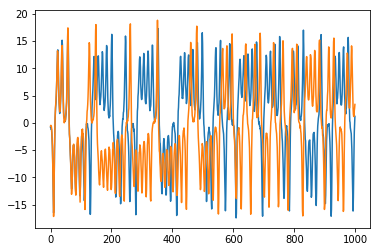

In [213]:
figtest = plt.figure()
#plt.plot(ressug[:1000,1])
#plt.plot(x_nature[:1000])
plt.plot(x_obs_import[:1000])
plt.plot(x_obs[:1000])

print(x_obs_import.mean())
print(x_obs.mean())

# print(x_obs_ressug.shape)
# print(x_obs_import.shape)

x_obs = x_obs_import

In [116]:
var = [0.02, 0.05, 0.0838, 0.1, 0.2]
K = len(var)

# ensemble size
M = 1000
repetitions = 10

evidenceSIR = np.ones((repetitions,K))

# SIR filter
dt = 0.001
Nout = 50
STEPS = 5*40
R = 1./15
sigma = R

for kk in range(K):
    for ll in range(repetitions):
        # initial conditions
        x0 = -0.587
        y0 = -0.563
        z0 = 16.87
        
        x = x0 + np.sqrt(sigma) * np.random.randn(M)
        y = y0 + np.sqrt(sigma) * np.random.randn(M)
        z = z0 + np.sqrt(sigma) * np.random.randn(M)
        time = np.zeros((STEPS+1))
        
        weights = 1./M * np.ones((M))
        
        for j in range(STEPS):
            xh = x
            yh = y
            zh = z
            
            for i in range(Nout):
                xo = xh
                yo = yh
                zo = zh

                xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var[kk]) * np.random.randn(M)
                yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var[kk]) * np.random.randn(M)
                zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var[kk]) * np.random.randn(M)
                
            r = xh - x_obs[j+1]
            weights = np.exp(-r**2 / (R * 2.)) * weights / np.sqrt(2. * np.pi * R)
            Weights = weights / np.sum(weights)
            
            x = xh
            y = yh
            z = zh
            time[j+1] = dt * Nout * j
            
            X = np.vstack((x,y,z))
            A, B = resampling(X,Weights,M,3)

            evidenceSIR[ll,kk] *= np.sum(weights)
            weights = 1./M * np.ones((M))
            
            x = np.hstack((A[0,:],B[0,:]))
            y = np.hstack((A[1,:],B[1,:]))
            z = np.hstack((A[2,:],B[2,:]))
            
evidences = np.mean(evidenceSIR,axis=0)

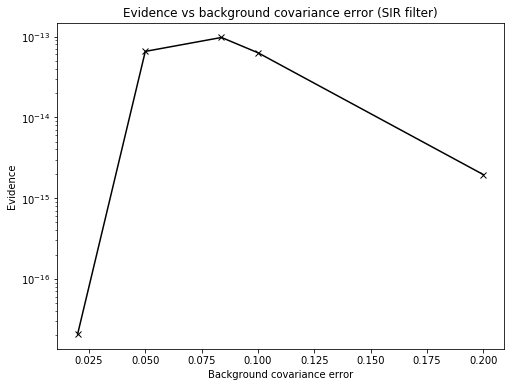

In [118]:
fig0 = plt.figure(figsize=(8,6))
plt.semilogy(var,evidenceSIR.mean(axis=0), '-kx')
plt.title("Evidence vs background covariance error (SIR filter)")
plt.xlabel("Background covariance error")
plt.ylabel("Evidence")
plt.show()

#fig0.savefig("fig_MODELSELECTION.pdf", bbox_inches='tight')

### Example 9.6 (Parameter estimation with the ESRF)

In [194]:
Nout = 100
dtobs = 0.1
dt = dtobs/Nout
STEPS = 20000
CAL = 100

# variance of observation error
R = 8.0

inflation = 1.02
# ensemble size
M = 20

sigma = np.zeros(STEPS+1)
# initial conditions
u = np.array([-0.587276,-0.563678,16.8708,9.])
uinit = np.copy(u)

time = np.zeros((STEPS+1))
yobs = np.zeros((3,STEPS+1))
time[0] = 0.

yobs[:,0] = u[:3] + np.sqrt(R) * np.random.randn(3)

ur = np.zeros((4,STEPS+1))
ur[:,0] = u

X = np.zeros((4,M))
X[:3,:] = 1.0 * np.random.randn(3,M)
# helps to generate U[7,11].
X[3,:] = 4. * (np.random.rand(M) - 0.5)
# X = X - ensemble average of X + the initial conditions u
X = X - np.dot(X,np.ones((M,M)))/M + np.repeat(u.reshape(-1,1),M,axis=1)
sigma[0] = u[3]

# ESRF
w = np.ones((M,1))/M
e = np.ones((M,1))
PP = np.eye(M) - np.dot(w,e.T)
xmean = np.dot(X,w)
errorEnKF = 0.

####################################
# 
# might want to write update step as a function....
#
# def updateSTEP(u0,u1,dt,lam=None):
#     um = (u1 + u0)/2
#     x = um[0]
#     y = um[1]
#     z = um[2]
#     if lam==None:
#         lam = um[3]

#     Fx = lam*(y-x)
#     Fy = x*(28.-z)-y
#     Fz = x*y - 8./3*z
#     Fl = abs(0.*np.array(Fx))
    
#     # fix this lazy fix!
#     if len(Fx.shape) > 0:
#         F = np.vstack((Fx,Fy,Fz,Fl))
#     else:
#         F = np.hstack((Fx,Fy,Fz,Fl))
        
#     u = u0 + dt * F
#     return u
#
#####################################

for i in range(STEPS):
    # reference solution
    for _ in range(Nout):
        u0 = np.copy(u)
        u1 = np.copy(u)
        
        # implicit mid-point rule
        for _ in range(4):
            um = (u1 + u0)/2
            x = um[0]
            y = um[1]
            z = um[2]

            Fx = 10.*(y-x)
            Fy = x*(28.-z)-y
            Fz = x*y - (8./3) *z
            Fl = abs(0.*np.array(Fx))
            F = np.hstack((Fx,Fy,Fz,Fl))

            u = u0 + dt * F
            u1 = np.copy(u)
    
    time[i+1] = dt * Nout * (i+1)
    # generate observation
    yobs[:,i+1] = u[:3] + np.sqrt(R) * np.random.randn(3)
    ur[:,i+1] = u
    
    # numerical solution (imperfect model scenario)
    for _ in range(Nout):
        X0 = np.copy(X)
        X1 = np.copy(X)
        
        for _ in range(4):
            Xm = (X1 + X0)/2
            x = Xm[0]
            y = Xm[1]
            z = Xm[2] 
            
            # lambda != 10.
            Fx = Xm[3]*(y-x)
            Fy = x*(28.-z)-y
            Fz = x*y - (8./3) *z
            Fl = abs(0.*np.array(Fx))
            F = np.vstack((Fx,Fy,Fz,Fl))
            
            X = X0 + dt * F
            X1 = np.copy(X)

    xmean = np.dot(X,w)
    dX = inflation * np.dot(X,PP)

    # forecast covariance matrix
    Psi = 1./(M-1) * np.dot(dX,dX.T)
    Pinv = np.linalg.inv(Psi[:3,:3] + R*np.eye(3))
    
    # see above eqn 7.22: S = [...]**2
    T = np.eye(M) - 1./(M-1) * np.dot(np.dot(dX[:3,:].T,Pinv),dX[:3,:])
    U,D,V = np.linalg.svd(T)
    # A^(1/2) = U*D^(1/2)*V if A is diagonalization
    # ref: https://en.wikipedia.org/wiki/Square_root_of_a_matrix
    T = np.dot(np.dot(U,sqrtm(np.diag(D))),V)

    # eqn 7.17, 2nd term on the right (RHS2).
    # Pa^(1/2) = 1/(M-1) * dX * T; Pmf^(-1/2) = (M-1)/dX; So RHS2 = TdX
    dX = np.dot(dX,T)
    
    # Kalman update step by means of the Kalman gain matrix (eqn 7.8, eqn 7.10)
    xmean = xmean - np.dot(np.dot(Psi[:,:3],Pinv), (xmean[:3] - yobs[:,i+1].reshape(-1,1)))
    X = np.dot(xmean,e.T) + dX
    
    sigma[i+1] = xmean[3]
    
    # record values only after calibration.
    if i >= CAL:
        errorEnKF += np.linalg.norm((xmean - ur[:,i+1])/np.sqrt(3))**2
        
errorEnKF = np.sqrt(errorEnKF / (i-CAL))

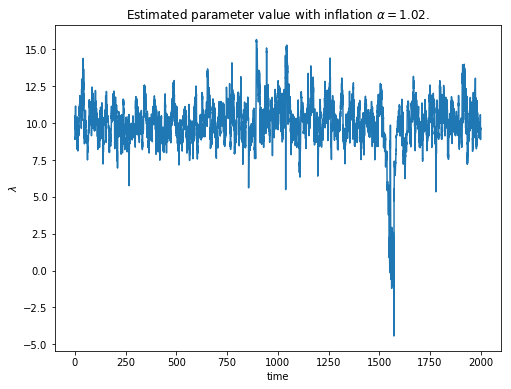

parameter value = 9.9945


In [208]:
fig1a = plt.figure(figsize=(8,6))
plt.plot(time,sigma,'-')
plt.xlabel("time")
plt.ylabel("$\lambda$")
plt.title(r"Estimated parameter value with inflation $\alpha = $%.2f." %inflation)
plt.show()
print("parameter value = %.4f" %(sigma.mean()))

### Example 9.8 (Parameter estimation: pseudo-marginal MCMC method by means of SIR)

In [247]:
var = 0.0838
M = 20

MCMC_SAMPLES = 10000
ev_old = 0.
lam_old = 9.

dt = 0.001
Nout = 50
STEPS = 20
R = 1./15
sigma = R

STEPS = 10

evidenceSIR = np.ones((MCMC_SAMPLES))
parameter = np.zeros((MCMC_SAMPLES))

for kk in range(MCMC_SAMPLES):
    # eqn 9.16. Draw a new ensemble from the previous accepted parameter.
    lamb = 9. + 4. * (np.random.rand() - 0.5)
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(R) * np.random.randn(M)
    y = y0 + np.sqrt(R) * np.random.randn(M)
    z = z0 + np.sqrt(R) * np.random.randn(M)
    time = np.zeros((STEPS+1))
    
    weights = 1./M * np.ones((M))
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh

            xh = xo + dt * lamb * (yo - xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)

        r = xh - x_obs[j+1]
        weights = np.exp(-r**2/(R*2.)) * weights / np.sqrt(2. * np.pi * R)
        Weights = weights / np.sum(weights)

        x = xh
        y = yh
        z = zh

        time[j+1] = dt * Nout * (j+1)
        # why is the effective here this way? And not 1/sum((wi)**2)?
        effective = np.float(M)/(1. + np.mean((M*Weights - 1.)**2))

        # resampling
        if (effective < float(M)/2.):
            X = np.vstack((x,y,z))
            A, B = resampling(X,Weights,M,3)
            evidenceSIR[kk] *= np.sum(weights)
            weights = np.ones(M)/M
            
            x = np.hstack((A[0,:],B[0,:]))
            y = np.hstack((A[1,:],B[1,:]))
            z = np.hstack((A[2,:],B[2,:]))
            
    evidenceSIR[kk] *= np.sum(weights)
    
    # this is different from algorithm 9.2 ... why draw xi again?
    if (evidenceSIR[kk] >= ev_old):
        parameter[kk] = lamb
        ev_old = evidenceSIR[kk]
        par_old = lamb
    else:
        xi = np.random.rand()
        if (evidenceSIR[kk] / ev_old > xi):
            parameter[kk] = lamb
            ev_old = evidenceSIR[kk]
            par_old = lamb
        else:
            parameter[kk] = par_old
            evidenceSIR[kk] = ev_old

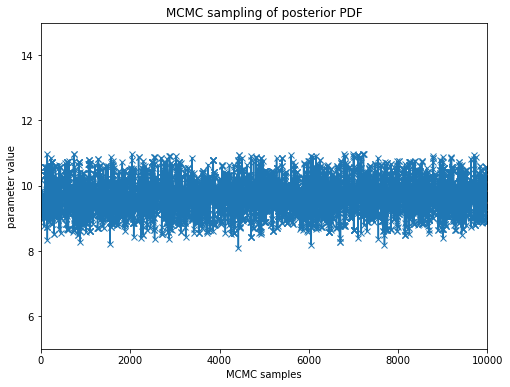

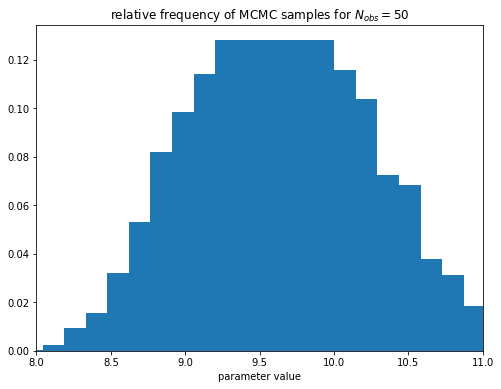

In [249]:
fig2a = plt.figure(figsize=(8,6))
plt.plot(parameter,'x-')
plt.xlabel("MCMC samples")
plt.ylabel("parameter value")
plt.title("MCMC sampling of posterior PDF")
plt.xlim([0,10000])
plt.ylim([5,15])
plt.show()

fig2b = plt.figure(figsize=(8,6))
nn, xh = np.histogram(parameter,20)
xh = (xh[1:] + xh[:-1])/2
nn = nn.astype('float')
nn = nn/np.sum(nn)#/(xh[1]-xh[0])
plt.bar(xh,nn)
plt.xlabel("parameter value")
plt.xlim([8.0,11.0])
plt.title("relative frequency of MCMC samples for $N_{obs} = %i$" %Nout)
plt.show()

### Example 9.12 (Continuous vs standard non-linear EnKF)

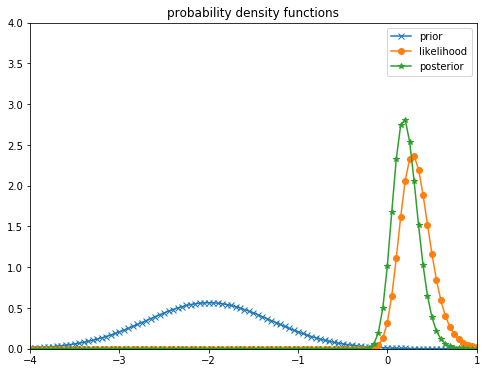

In [297]:
R = 1.
B = 1./2
yobs = 2.

# ensemble size
M = 2000
x0 = -2. + np.sqrt(B) * np.random.randn(M)
x = x0

dx = 0.05
xgrid = np.arange(-4,1+dx,dx)
prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid + 2.)**2 / (2. * B))
prior /= (dx*np.sum(prior))
y = 7./12 * xgrid**3 - 7./2 * xgrid**2 + 8. * xgrid
lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(y-yobs)**2 / (2. * R))
lik /= (dx*np.sum(lik))
post = lik*prior / (np.sum(lik*prior)*dx)

post_mean = np.sum(post * xgrid * dx)

fig3a = plt.figure(figsize=(8,6))
plt.plot(xgrid, prior, '-x')
plt.plot(xgrid, lik, '-o')
plt.plot(xgrid, post, '-*')
plt.legend(["prior", "likelihood", "posterior"])
plt.title("probability density functions")
plt.ylim([0,4])
plt.xlim([-4,1])
plt.show()

In [298]:
STEPS = 2000
ds = 1./STEPS

# continuous EnKF
for j in range(STEPS):
    xm = np.mean(x)
    y = 7./12 * x**3 - 7./2 * x**2 + 8.*x
    
    # perturbed observations
    yobs_rand = yobs + np.sqrt(R/ds) * np.random.randn(M)
    dy = y - yobs_rand
    
    # eqn 9.32 - Pzh; extension of the linear EnKF to non-linear EnKF.
    P = 1./(M-1) * np.sum((y-np.mean(y))*(x-xm))
    # the second term of eqn 9.33 is absorbed by yobs_rand
    x = x - ds * P/R * dy
    
continuous_mean = xm

# standard EnKF
yobs_rand = yobs + np.sqrt(R)*np.random.randn(M)

xm0 = np.mean(x0)
y = 7./12 * x0**3 - 7./2 * x0**2 + 8.*x0
dy = y - yobs_rand
# non-linear forward operator covariance matrix
P = 1./(M-1.) * np.sum((y-np.mean(y))*(x0-xm0))
Py = 1./(M-1.) * np.sum((y-np.mean(y))**2)

# Kalman update step for non-linear forward operators
xx = x0 - P/(Py+R)*dy

standard_mean = np.mean(xx)

print("posterior mean: %.4f" %post_mean)
print("continuous EnKF mean: %.4f" %continuous_mean)
print("EnKF mean: %.4f" %standard_mean)

posterior mean: 0.2095
continuous EnKF mean: 0.1739
EnKF mean: -0.7116


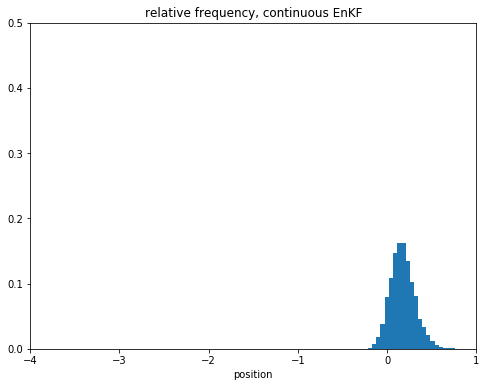

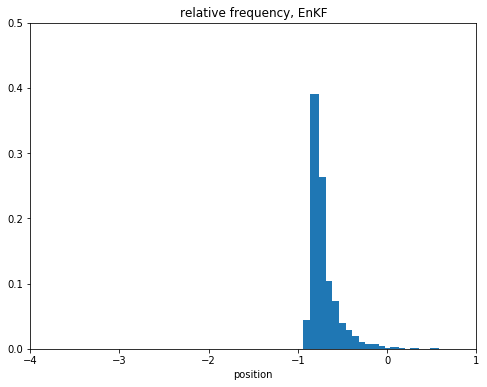

In [302]:
fig3b = plt.figure(figsize=(8,6))
nn0,xh0 = np.histogram(x,20)
xh0 = (xh0[1:] + xh0[:-1])/2
nn0 = nn0.astype('float')
nn0 = nn0/np.sum(nn0)
plt.bar(xh0,nn0,width=0.1)
plt.xlim([-4,1])
plt.ylim(0,0.5)
plt.xlabel("position")
plt.title("relative frequency, continuous EnKF")
plt.show()

fig3c = plt.figure(figsize=(8,6))
nn1,xh1 = np.histogram(xx,20)
xh1 = (xh1[1:] + xh1[:-1])/2
nn1 = nn1.astype('float')
nn1 = nn1/np.sum(nn1)
plt.bar(xh1,nn1,width=0.1)
plt.xlim([-4,1])
plt.ylim(0,0.5)
plt.xlabel("position")
plt.title("relative frequency, EnKF")
plt.show()

### Example 9.14 (Deterministic Lorenz-63 model with continuous-in-time observations)

In [441]:
dt = 0.0025
CAL = 100
STEPS = 4000 + CAL

M = 20
Ro = 1.0
H = [1.,0.,0.]

# initial conditions
u = np.array([-0.587276,-0.563678,16.8708])
uinit = u

ur = np.zeros((3,STEPS+1))
uf = np.zeros((3,STEPS+1))
ur[:,0] = np.copy(u)
uf[:,0] = np.copy(u)

time = np.zeros((STEPS+1))
dy = np.zeros((STEPS+1))
time[0] = 0.

def RHS(u):
    x = u[0]
    y = u[1]
    z = u[2]
    xx = 10.*(y-x)
    yy = x*(28.-z) - y
    zz = x*y - (8./3) * z
    return np.array([xx,yy,zz])

# initial observation
F = RHS(u)
dy[0] = np.dot(H,F.T)*dt + np.sqrt(dt * Ro) * np.random.randn()

# initial ensemble
sigma = 0.01
X = np.sqrt(sigma) * np.random.randn(3,M)
X = X - np.dot(X,np.ones((M,M)))/M + np.dot(u.reshape(-1,1),np.ones((1,M)))

#####################################
#
# continuous ensemble Kalman filter
#
#####################################

w = np.ones((M,1))/M
e = np.ones((M,1))
PP = np.eye(M) - np.dot(w,e.T)

xmean = np.dot(X,w)
err = 1./2 * np.dot(xmean.T,xmean)

error1EnKF = 0.
error2EnKF = 0.

for i in range(STEPS):
    # propagate reference solution
    u0 = np.copy(u)
    F = RHS(u0)
    u = u0 + dt * F
    
    time[i+1] = dt * (i+1)
    ur[:,i+1] = np.copy(u)
    
    # generate an observation
    F = RHS(u)
    dy[i+1] = np.dot(H,F.T)*dt + np.sqrt(dt * Ro) * np.random.randn()
    
    # propogate forecast ensemble and assimilate observation
    Xn = np.copy(X)
    FX = RHS(Xn)
    dXn = np.dot(Xn,PP)
    dYn = np.dot(np.dot(H,FX),PP)
    # cross covariance matrix
    Pn = 1./(M-1.) * np.dot(dXn,dYn.T)

    # Kalman update step (eqn 9.47)
    T21 = (np.dot(H,FX)*dt).reshape(1,-1)
    T22 = dy[i+1]*e.T
    T23 = np.sqrt(dt * Ro) * np.dot(np.random.randn(1,M),PP)
    X = X + dt * FX - np.dot((Pn/Ro).reshape(-1,1),(T21 - T22 + T23))
    
    # Diagnostics
    xmean = np.dot(X,w).flatten()
    uf[:,i+1] = xmean
    # start recording error after calibration
    if (i > CAL):
        error1EnKF = error1EnKF + np.linalg.norm(np.dot(H,(xmean-ur[:,i+1])))**2
        error2EnKF = error2EnKF + np.linalg.norm((xmean - ur[:,i+1]) / np.sqrt(3.))**2
        
error1EnKF = np.sqrt(error1EnKF / (i-CAL))
error2EnKF = np.sqrt(error2EnKF / (i-CAL))

time-averaged RMSE in x-component: 0.1933
time-averaged RMSE over all components: 0.3130


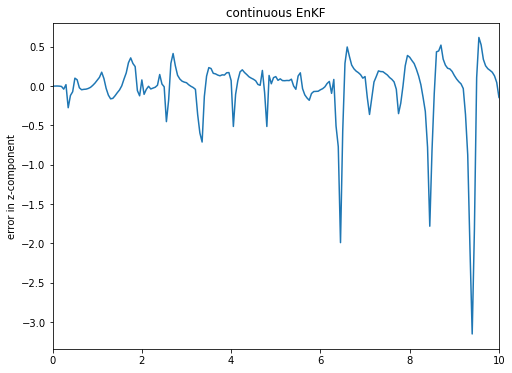

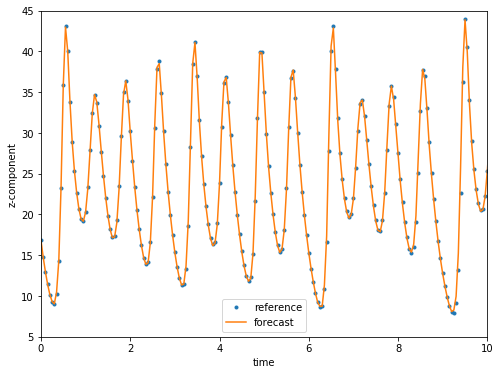

In [443]:
print("time-averaged RMSE in x-component: %.4f" %error1EnKF)
print("time-averaged RMSE over all components: %.4f" %error2EnKF)

fig4a = plt.figure(figsize=(8,6))
plt.plot(time[::20],ur[2,::20]-uf[2,::20])
plt.title("continuous EnKF")
plt.ylabel("error in z-component")
plt.xlim([0,10])
#plt.ylim([-2,2])
plt.show()

fig4b = plt.figure(figsize=(8,6))
plt.plot(time[::20],ur[2,::20], '.')
plt.plot(time[::20],uf[2,::20], '-')
plt.legend(["reference","forecast"])
plt.xlabel("time")
plt.ylabel("z-component")
plt.xlim([0.0,10.0])
plt.ylim([5.0,45.0])
plt.show()